In [1]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import proplot as plot
import pandas as pd
from glob import glob

import epicc_config as cfg

from matplotlib.ticker import MaxNLocator

from wrf import (to_np, getvar,get_cartopy, cartopy_xlim,GeoBounds,CoordPair,
                 cartopy_ylim, latlon_coords)


wrun = cfg.wrf_runs[0]
reg = 'EPICC'

In [2]:
geo_file = xr.open_dataset(cfg.geofile_ref)
lm_is=geo_file.LANDMASK.squeeze()

In [3]:
def get_geoinfo():

    fileref = nc.Dataset(f'{cfg.path_wrfout}/{wrun}/out/{cfg.file_ref}')
    hgt = getvar(fileref, "ter")
    lats, lons = latlon_coords(hgt)
    cart_proj = get_cartopy(hgt)

    return cart_proj,lats,lons,hgt

def map_bounds(reg):

    if reg=='EPICC':
        mbounds = None
    else:
        mbounds = GeoBounds(CoordPair(lat=cfg.reg_coords[reg][0], lon=cfg.reg_coords[reg][1]),
                               CoordPair(lat=cfg.reg_coords[reg][2], lon=cfg.reg_coords[reg][3]))
    return mbounds

In [4]:
cart_proj,lats,lons,hgt = get_geoinfo()
mbounds = map_bounds(reg)

In [5]:
all_files = sorted(glob('/vg6/dargueso-NO-BKUP/OBS_DATA/AEMET_MED_hifreq/Arnau_*.txt'))     # advisable to use os.path.join as this makes concatenation OS independent
df_from_each_file = (pd.read_csv(f, sep=';',header=0,encoding = "ISO-8859-1") for f in all_files)
prec_data   = pd.concat(df_from_each_file, ignore_index=True)
prec_data['dateInt']=prec_data['ANO'].astype(str) + prec_data['MES'].astype(str).str.zfill(2)+ prec_data['DIA'].astype(str).str.zfill(2)
prec_data['Date'] = pd.to_datetime(prec_data['dateInt'], format='%Y%m%d')
stn_info = prec_data.take(prec_data['INDICATIVO'].drop_duplicates().index)


In [6]:
stn_info = stn_info.reset_index()
stn_info = stn_info[['INDICATIVO','NOMBRE','ALTITUD','CMT','NOM_PROV','LONGITUD','LATITUD']]
stn_info['LONGITUD'] = stn_info['LONGITUD'].astype(str).str.zfill(7)
stn_info['LATITUD'] = stn_info['LATITUD'].astype(str).str.zfill(6)

In [7]:
for i, row in stn_info.iterrows():

    lon_str = row.LONGITUD
    if int(lon_str[-1])==1:
        new_lon = float(lon_str[:2])+float(lon_str[2:4])/60.+float(lon_str[4:6])/3600.
    elif int(lon_str[-1])==2:
        new_lon = -(float(lon_str[:2])+float(lon_str[2:4])/60.+float(lon_str[4:6])/3600.)

    lat_str = row.LATITUD
    new_lat = float(lat_str[:2])+float(lat_str[2:4])/60.+float(lat_str[4:6])/3600.
    
    stn_info.at[i,'LONGITUD'] = new_lon
    stn_info.at[i,'LATITUD'] = new_lat

    stn = row.INDICATIVO
    print(stn)
    stn_max = prec_data[prec_data.INDICATIVO==stn].PMAX10.max()
    stn_info.loc[stn_info.INDICATIVO==stn,'PMAX10']=stn_max/10.


0002I
0016A
0034C
0034X
0042X
0076
0149D
0158X
0162C
0200E
0201D
0208
0213X
0222
0222X
0229I
0237
0252D
0281X
0321
0324A
0341
0367
0370X
0385X
0394X
0411X
4267E
4267X
4527X
4541X
4548X
4549Y
4560X
4642E
5000B
5000C
5008I
5047E
5051X
5181D
5246
5270B
5279X
5298X
5390Y
5402
5427X
5514
5530E
5582A
5612X
5624X
5641X
5704B
5733X
5783
5790X
5796
5860E
5910
5911A
5960
5972
5972X
5973
5995B
6000A
6001
6032B
6058I
6069X
6076X
6084X
6106X
6143X
6155A
6156X
6172O
6201X
6205X
6213X
6268X
6277B
6291B
6302A
6325O
6332X
6367B
7002X
7012C
7031
7118B
7138X
7145D
7178I
7209
7227X
7228
7247X
7261X
7275B
8019
8025
8050X
8058X
8059X
8293X
8309X
8325X
8368U
8414A
8416
8500A
8523X
9201K
9244X
9381I
9390
9394X
9434
9443R
9443U
9460X
9531X
9563X
9573X
9574X
9576C
9585
9619
9698U
9720X
9771C
9894X
9898
9918X
9935X
9981A
9987P
9990X
0009X
0042Y
0061X
0066X
0073X
0092X
0106X
0114X
0120X
0149X
0158O
0189E
0194D
0201X
0230
0244X
0249U
0255B
0260X
0281A
0281Y
0284X
0312X
0320I
0360X
0363X
0370E
0394
0421E
0421X
0429

In [8]:
stn_info=stn_info.where(stn_info.PMAX10>0,0)

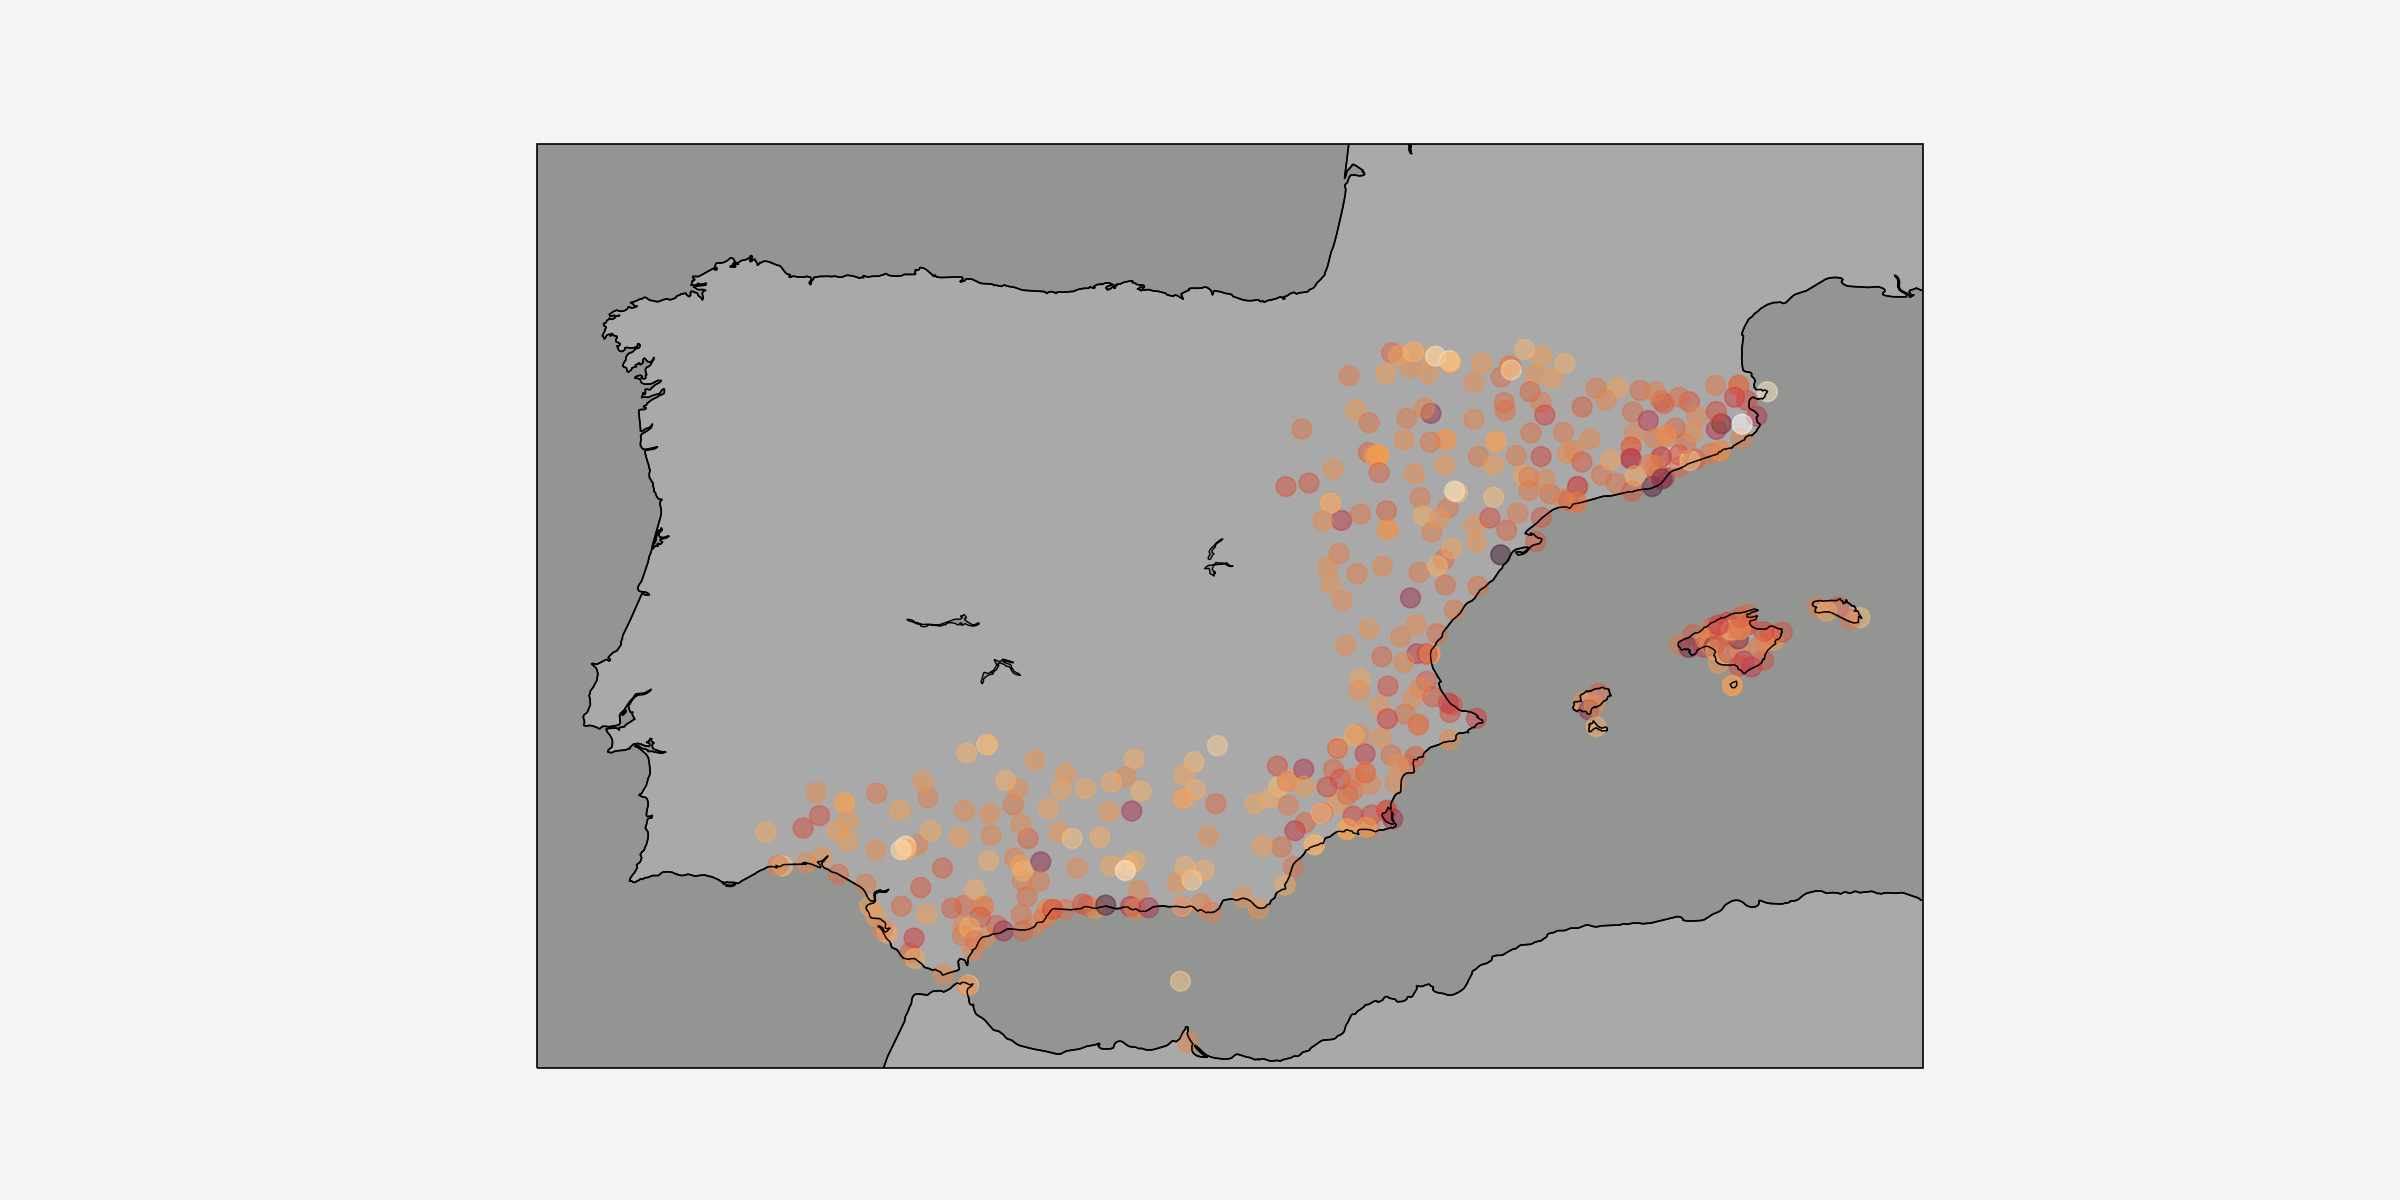

In [9]:
#Draw simple map
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.OCEAN,facecolor='gray')
ax.add_feature(cfeature.LAND, edgecolor='k',facecolor='darkgray')
ax.add_feature(cfeature.LAKES,linewidth=0.5,edgecolor='k',facecolor='gray')

ax.set_extent([-10, 5, 35, 45],
              crs=ccrs.PlateCarree()) ## Important

plt.scatter(x=stn_info.LONGITUD, y=stn_info.LATITUD,
            c=stn_info.PMAX10,
            edgecolor='face',
            s=50,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important


/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/dargueso/anaconda3/envs/e3_epicc_env/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_

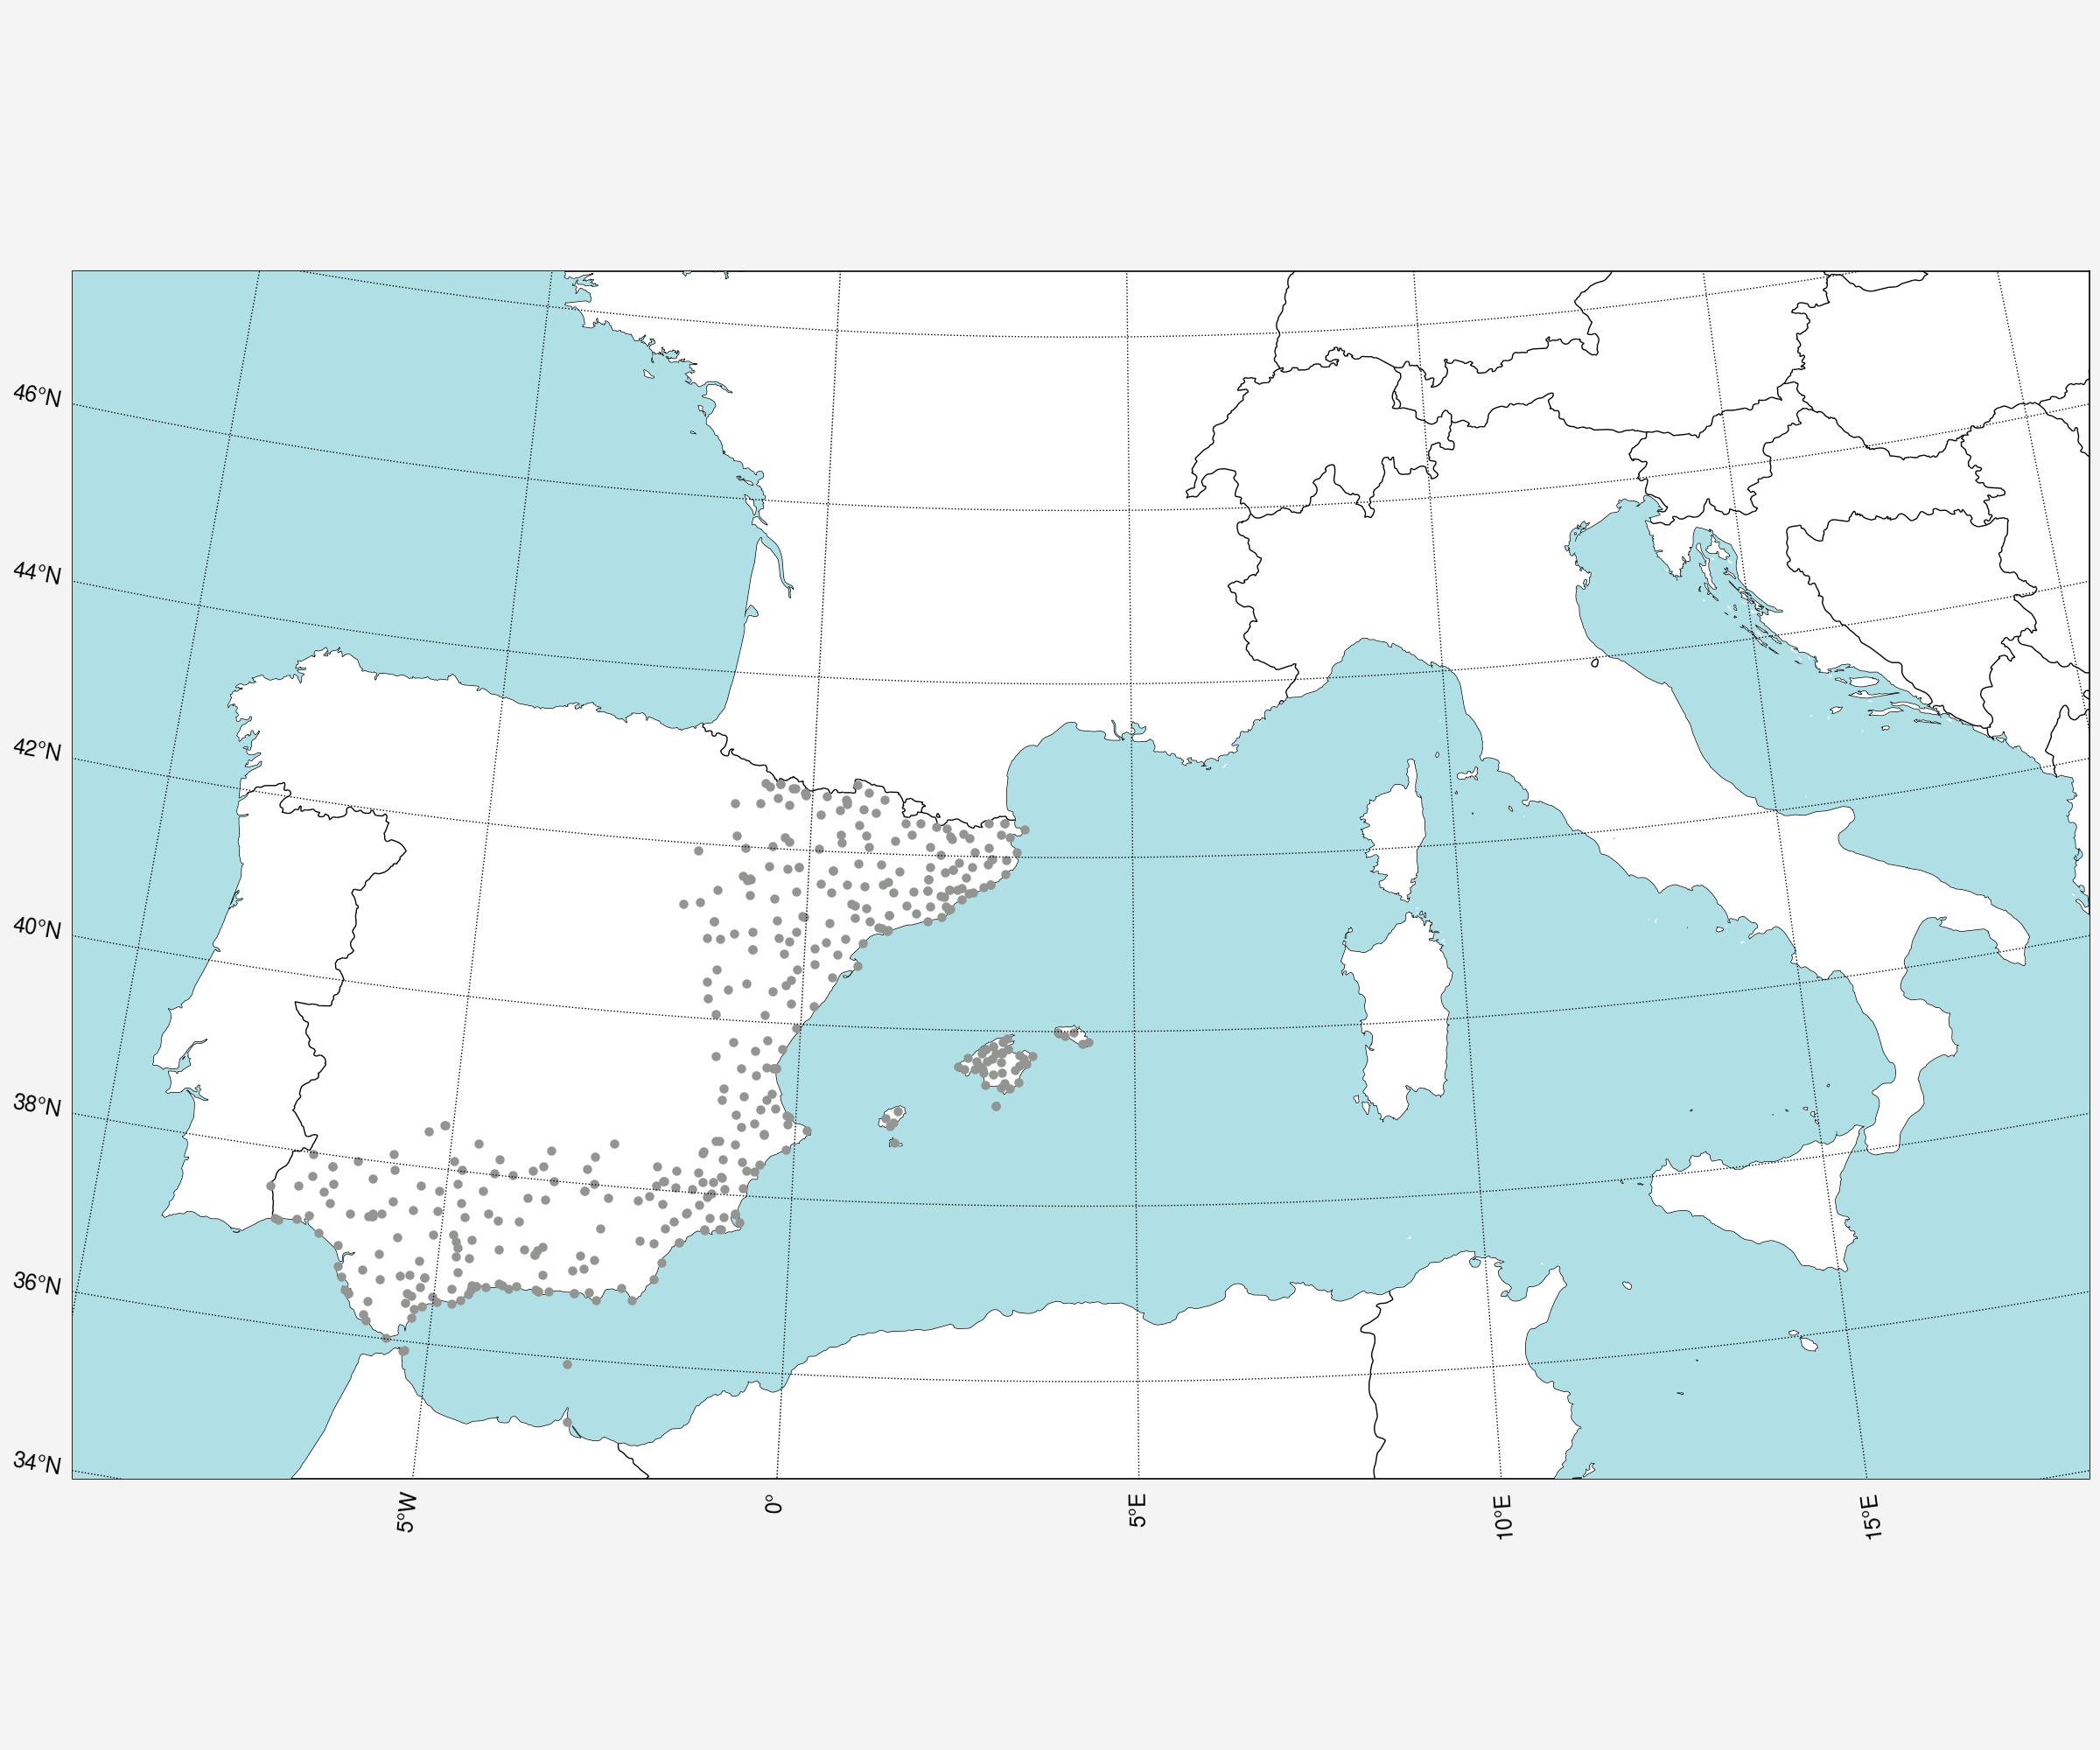

In [13]:
#Plotting
# Create a figure
fig, axs = plot.subplots(width=12,height=10,ncols=1,nrows=1,proj=cart_proj)
axs.format(
        suptitle="",
        suptitlesize='xx-large',
        abc=False,
    )

axs[0].add_feature(cfeature.COASTLINE,linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5)

oce50m = cfeature.NaturalEarthFeature('physical', 'ocean', '10m')
lakes50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
land50m = cfeature.NaturalEarthFeature('physical', 'land', '10m')
axs[0].add_feature(oce50m , zorder=100,facecolor='powderblue')
#axs[0].add_feature(lakes50m, zorder=100,linewidth=0.5,edgecolor='k',facecolor=[197/255,  230/255,  219/255])
#axs[0].add_feature(land50m, zorder=100,edgecolor='k',facecolor='lightgray')

axs[0].scatter(x=stn_info.LONGITUD, y=stn_info.LATITUD,
            s=10,c='gray',
            transform=ccrs.PlateCarree(),zorder=101) ## Important


cmap = plot.Colormap('IceFire')

cmap_kw = {'left': 0}
# m0=axs[0].contourf(to_np(lons), to_np(lats), hgt.where(lm_is>0),
#                  transform=ccrs.PlateCarree(),cmap=cmap,
#                  cmap_kw=cmap_kw,levels = range(0,3200,200),extend='both',colorbar='b')
axs[0].set_xlim(cartopy_xlim(hgt,geobounds=mbounds))
axs[0].set_ylim(cartopy_ylim(hgt,geobounds=mbounds))
gl0=axs[0].gridlines(color="black", linestyle="dotted",linewidth=0.5,draw_labels=True,x_inline=False, y_inline=False,zorder=101)
gl0.right_labels=False
gl0.top_labels=False    

plt.savefig(f'{cfg.path_out}/WRF_General/EPICC_domain_obs_AEMET_MED_hifreq_{reg}.pdf')